In [2]:
! pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ujjwalkathait","key":"0763de37913d00a0d737df2e8ce29fae"}'}

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.75G/1.76G [00:21<00:00, 97.3MB/s]
100% 1.76G/1.76G [00:21<00:00, 87.1MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('lung-and-colon-cancer-histopathological-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn import metrics
import cv2
import gc
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [7]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Step 2: Data Visualization
path = '/content/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_n', 'lung_scc', 'lung_aca']

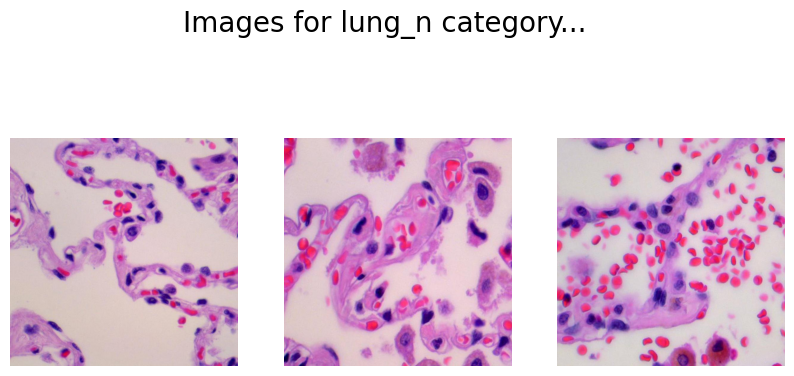

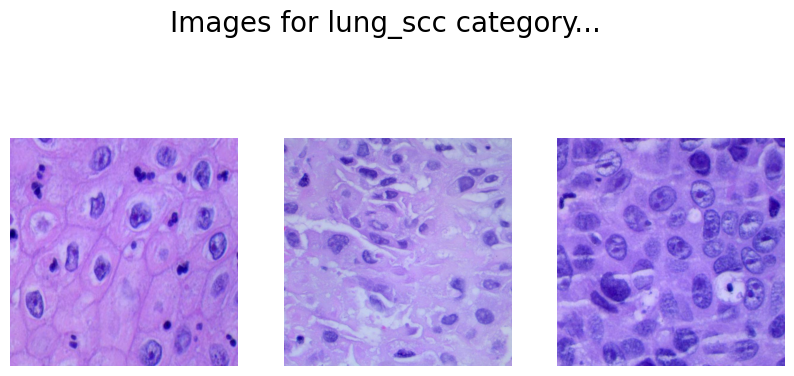

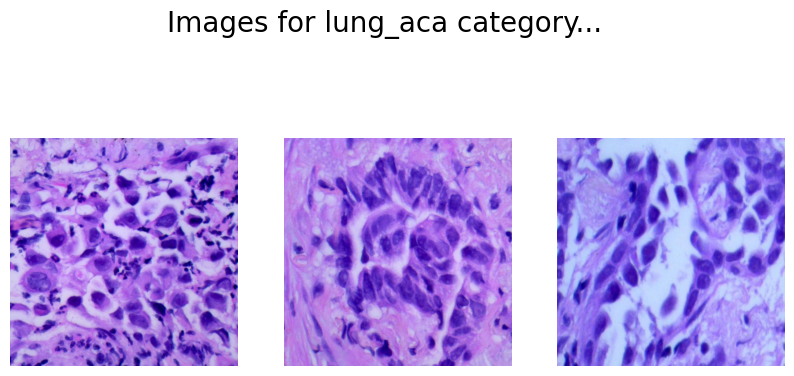

In [9]:
# Display random images from each class
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    # Display 3 random images for each class
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    fig.suptitle(f'Images for {cat} category...', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


array([[[211, 195, 240],
        [211, 195, 240],
        [211, 195, 240],
        ...,
        [152,  84, 223],
        [154,  86, 225],
        [156,  88, 227]],

       [[211, 195, 240],
        [211, 195, 240],
        [212, 196, 241],
        ...,
        [154,  86, 225],
        [155,  87, 226],
        [156,  88, 227]],

       [[211, 195, 240],
        [212, 196, 241],
        [212, 196, 241],
        ...,
        [155,  87, 226],
        [157,  86, 228],
        [157,  86, 228]],

       ...,

       [[170, 102, 215],
        [171, 103, 216],
        [172, 102, 216],
        ...,
        [171, 138, 229],
        [176, 143, 232],
        [179, 146, 235]],

       [[166,  99, 214],
        [167, 100, 215],
        [168, 100, 213],
        ...,
        [171, 138, 227],
        [177, 144, 233],
        [181, 148, 237]],

       [[164,  97, 212],
        [164,  97, 212],
        [166,  98, 211],
        ...,
        [172, 139, 228],
        [178, 145, 234],
        [182, 149, 238]]], dtype=uint8)
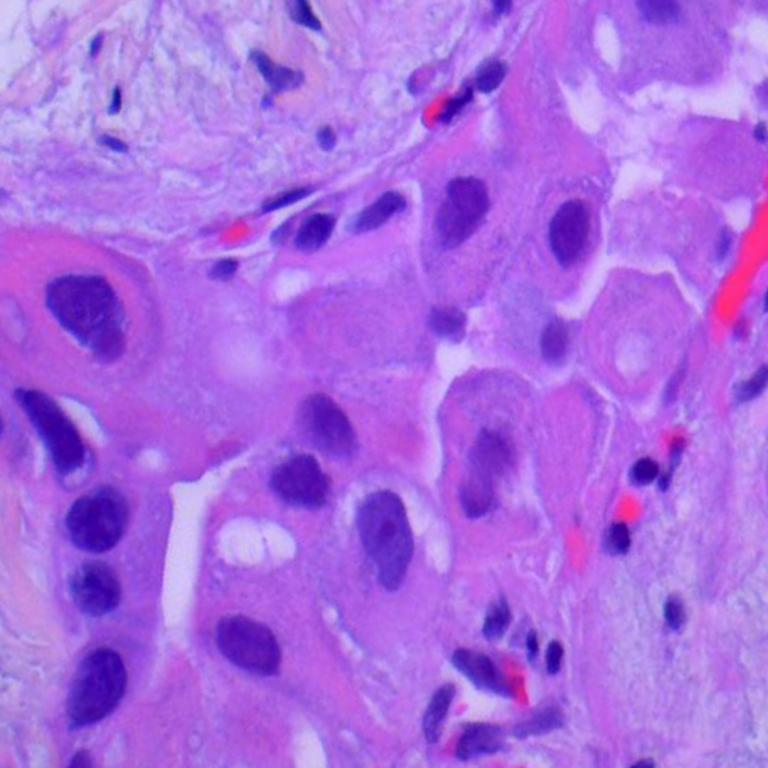

In [17]:
img = Image.open('lung_colon_image_set/lung_image_sets/lung_aca/lungaca1.jpeg')
img = np.array(img)
img

In [18]:
# Step 3: Data Preparation for Training
IMG_SIZE = 186
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 8

In [19]:
# Lists to store images and labels
X = []
Y = []

# Loop through each class
for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')
    # print(images)
    # Read and resize each image, append to lists
    for image in images:
        img = cv2.imread(image)
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

np.save('X2.npy', X)
np.save('Y2.npy', Y)

In [20]:
# Convert lists to NumPy arrays
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values
one_hot_encoded_Y[300]

array([ True, False, False])

In [21]:
# Split the dataset into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size=SPLIT,
                                                  random_state=2022)

In [24]:
# Model Development
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet',
    include_top=False
)

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 9, 9, 768)


In [25]:
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(3, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

In [26]:
# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 186, 186, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 92, 92, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_188   │ (None, 92, 92, 32)     │             96 │ conv2d_188[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 92, 92, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_189 (Conv2D)       │ (None, 90, 90, 32)     │          9,216 │ activation_188[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 90, 90, 32)     │             96 │ conv2d_189[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 90, 90, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_190 (Conv2D)       │ (None, 90, 90, 64)     │         18,432 │ activation_189[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 90, 90, 64)     │            192 │ conv2d_190[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 90, 90, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 44, 44, 64)     │              0 │ activation_190[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_191 (Conv2D)       │ (None, 44, 44, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 44, 44, 80)     │            240 │ conv2d_191[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 44, 44, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_192 (Conv2D)  

 Total params: 24,935,587 (95.12 MB)

 Trainable params: 15,959,555 (60.88 MB)

 Non-trainable params: 8,976,032 (34.24 MB)

In [27]:
# Visualize the model architecture
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.619543 to fit



In [28]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
# Step 5: Callbacks
# Define custom callback to stop training when validation accuracy reaches 90%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\nValidation accuracy has reached 90%, stopping further training.')
            self.model.stop_training = True

In [31]:
# Define EarlyStopping and ReduceLROnPlateau callbacks
# es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
# lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

In [32]:
# Step 6: Model Training
# Train the model with the training dataset and validate on the validation dataset
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1
                    # callbacks=[myCallback()]
                    )

model.save('lung_cancer_detection_model.h5')

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 51s 24ms/step - accuracy: 0.7014 - loss: 0.7198 - val_accuracy: 0.7517 - val_loss: 0.6718
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 68s 19ms/step - accuracy: 0.8167 - loss: 0.4410 - val_accuracy: 0.7817 - val_loss: 0.5759
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.8404 - loss: 0.3895 - val_accuracy: 0.8603 - val_loss: 0.4279
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.8518 - loss: 0.3737 - val_accuracy: 0.8423 - val_loss: 0.3864
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.8675 - loss: 0.3311 - val_accuracy: 0.6410 - val_loss: 1.3100
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.8745 - loss: 0.3203 - val_accuracy: 0.8997 - val_loss: 0.4708
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.8892 - loss: 0.2791 - val_accuracy: 0.9193 - val_loss: 0.2620
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.9006 -

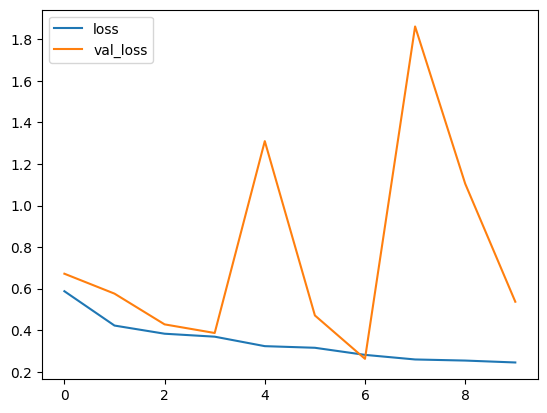

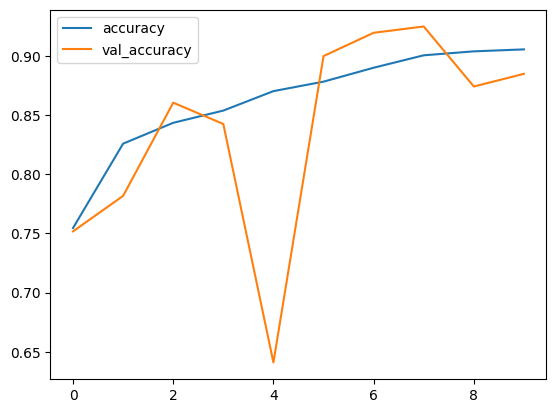

In [33]:
# Step 7: Visualize Training Metrics
# Plot training and validation loss over epochs
# Plot training and validation accuracy over epochs
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [34]:
# Step 8: Model Evaluation
# Predict class labels for the validation dataset
Y_pred = model.predict(X_val)
# print(Y_pred, Y_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)
# print(Y_pred, Y_val)


94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step


In [35]:
# Confusion matrix and classification report for model evaluation
print(metrics.confusion_matrix(Y_val, Y_pred))
print(metrics.classification_report(Y_val, Y_pred, target_names=classes))

[[983   0   4]
 [  5 919  53]
 [180 104 752]]
              precision    recall  f1-score   support

      lung_n       0.84      1.00      0.91       987
    lung_scc       0.90      0.94      0.92       977
    lung_aca       0.93      0.73      0.82      1036

    accuracy                           0.88      3000
   macro avg       0.89      0.89      0.88      3000
weighted avg       0.89      0.88      0.88      3000

